# Comparison of MEFISTO and PRISMO on Visium Data from MEFISTO paper

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:

import scanpy as sc
import matplotlib.pyplot as plt
import umap
import pandas as pd
import seaborn as sns
import numpy as np

from data_loader import load_mefisto_visium

from prismo.prismo import PRISMO, DataOptions, ModelOptions, TrainingOptions, SmoothOptions
from prismo.gpu import get_free_gpu_idx
from prismo.io import load_model
from prismo.downstream import match
from prismo.plotting import plot_training_curve, plot_variance_explained, plot_factor_correlation, plot_factors_scatter

/home/aqoku/miniconda3/envs/famo/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Importing the dtw module. When using in academic works please cite:
  T. Giorgino. Computing and Visualizing Dynamic Time Warping Alignments in R: The dtw Package.
  J. Stat. Soft., doi:10.18637/jss.v031.i07.



In [3]:
adata = load_mefisto_visium()
adata.var_names = adata.var_names.str.upper()
adata

/home/aqoku/miniconda3/envs/famo/lib/python3.10/site-packages/anndata/_core/anndata.py:1756: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
/home/aqoku/miniconda3/envs/famo/lib/python3.10/site-packages/anndata/_core/anndata.py:1756: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
/home/aqoku/miniconda3/envs/famo/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:275: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
/home/aqoku/projects/code/prismo-analysis/comparison_mefisto_visium/data_loader.py:31: ImplicitModificationWarning: Setting element `.obsm['spatial']` of view, initializing view as actual.


AnnData object with n_obs × n_vars = 2487 × 2000
    obs: 'in_tissue', 'array_row', 'array_col', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'n_counts'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'spatial', 'log1p', 'hvg'
    obsm: 'spatial'

<Axes: >

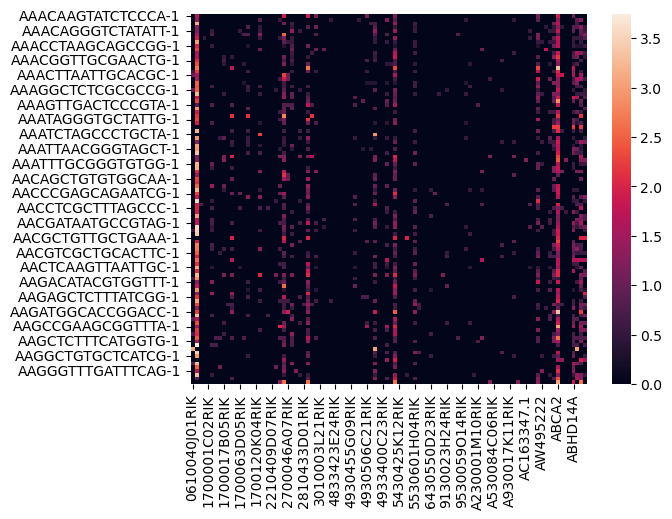

In [4]:
sns.heatmap(adata.to_df().iloc[:100, :100])

In [5]:
feature_stds = adata.to_df().std()
(feature_stds > 0).mean()

1.0

In [6]:
from prismo import feature_sets

In [7]:
def to_upper(feature_set_collection):
    return feature_sets.FeatureSets(
        [
            feature_sets.FeatureSet([f.upper() for f in fs], fs.name)
            for fs in feature_set_collection
        ],
        name=feature_set_collection.name,
    )

In [8]:
hallmark_collection = feature_sets.from_gmt(
    "../msigdb/mh.all.v2024.1.Mm.symbols.gmt", name="hallmark"
)


panglao_df = pd.read_csv("../msigdb/PanglaoDB_markers_27_Mar_2020.tsv", sep="\t")
panglao_df = panglao_df.loc[panglao_df["species"].isin(["Mm Hs", "Mm"]) & (panglao_df["organ"] == "Brain"), :].copy()

celltype_collection = feature_sets.from_dataframe(panglao_df.groupby("cell type").agg(list).reset_index(), name="celltype", name_col="cell type", features_col="official gene symbol", desc_col="product description")

# celltype_collection = feature_sets.from_gmt(
#     "../../msigdb/c8.all.v7.5.1.symbols.gmt", name="celltype"
# )

# merge both collections
gene_set_collection = celltype_collection
gene_set_collection = to_upper(gene_set_collection)
gene_set_collection
# sorted([fs.name for fs in gene_set_collection])

<FeatureSets 'celltype' with 34 feature sets>

In [9]:
gene_set_collection = gene_set_collection.filter(
    adata.var_names, min_fraction=0.1, min_count=5, max_count=300, 
)
# sorted([fs.name for fs in gene_set_collection])
gene_set_collection

<FeatureSets 'celltype' with 24 feature sets>

In [10]:
[gs.name for gs in gene_set_collection]

['Schwann cells',
 'Pyramidal cells',
 'Microglia',
 'Neurons',
 'Meningeal cells',
 'Tanycytes',
 'Immature neurons',
 'Choroid plexus cells',
 'Neuroendocrine cells',
 'GABAergic neurons',
 'Neural stem/precursor cells',
 'Ependymal cells',
 'Astrocytes',
 'Satellite glial cells',
 'Interneurons',
 'Oligodendrocyte progenitor cells',
 'Trigeminal neurons',
 'Cajal-Retzius cells',
 'Retinal ganglion cells',
 'Neuroblasts',
 'Purkinje neurons',
 'Dopaminergic neurons',
 'Bergmann glia',
 'Oligodendrocytes']

In [11]:
adata.varm["gene_set_mask"] = gene_set_collection.to_mask(
    adata.var_names.tolist()
).T

In [12]:
device = "cpu"
try:
    device = f"cuda:{get_free_gpu_idx()}"
except Exception as e:
    print(e)
device

'cuda:1'

In [13]:
data_opts = DataOptions(
    group_by=None, 
    scale_per_group=True, 
    covariates_obs_key=None, 
    covariates_obsm_key={"group_1" : "spatial"}, 
    use_obs="union", 
    use_var="union", 
    plot_data_overview=True
)

In [14]:
model_opts = ModelOptions(
    n_factors=1, 
    weight_prior={"view_1": "Horseshoe"}, 
    factor_prior={"group_1" : "GP"}, 
    likelihoods="Normal", 
    nonnegative_weights=True, 
    nonnegative_factors=True, 
    annotations=None, 
    annotations_varm_key={"view_1": "gene_set_mask"}, 
    prior_penalty=0.003, 
    init_factors="random", 
    init_scale=0.1
)

In [15]:
training_opts = TrainingOptions(
    device=device, 
    # batch_size=10000, 
    max_epochs=3000, 
    n_particles=1, 
    lr=0.003, 
    early_stopper_patience=100, 
    print_every=100, 
    save=False, 
    save_path=None, 
    seed=None
)

In [16]:
smooth_opts = SmoothOptions(
    n_inducing=100, 
    kernel="RBF", 
    warp_groups=[], 
    warp_interval=20, 
    warp_open_begin=True, 
    warp_open_end=True, 
    warp_reference_group=None
)

2024-10-28 17:14:45 | prismo.prismo | INFO | Setting up device...
2024-10-28 17:14:45 | prismo.prismo | INFO | - Using provided likelihood for all views.
2024-10-28 17:14:45 | prismo.prismo | INFO |   - view_1: Normal


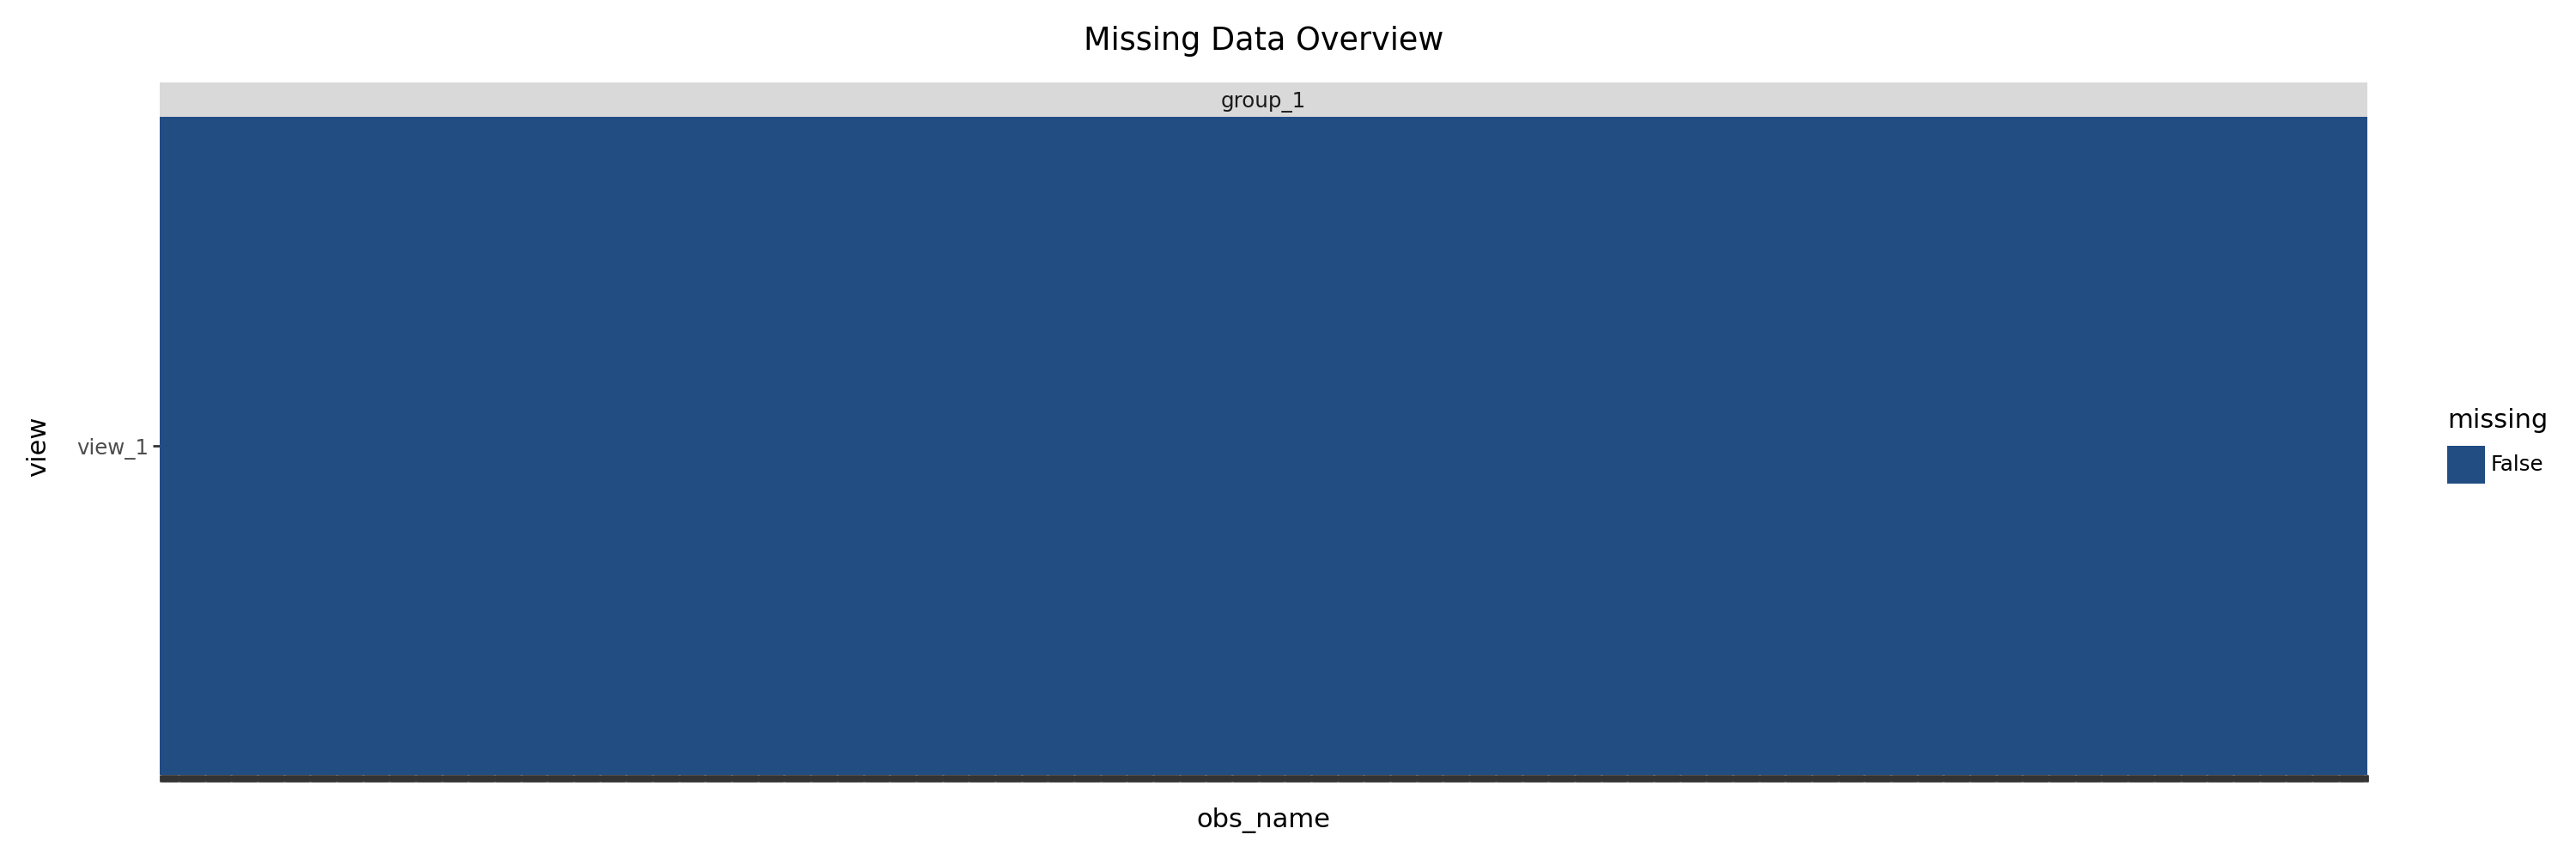

2024-10-28 17:14:55 | prismo.prismo | INFO | Initializing factors using `random` method...
2024-10-28 17:14:56 | prismo.prismo | INFO | Decaying learning rate over 3000 iterations.
2024-10-28 17:14:56 | prismo.prismo | INFO | Setting training seed to `2410281714`.
2024-10-28 17:14:56 | prismo.prismo | INFO | Cleaning parameter store.
/home/aqoku/miniconda3/envs/famo/lib/python3.10/site-packages/linear_operator/utils/interpolation.py:71: UserWarning: The torch.cuda.*DtypeTensor constructors are no longer recommended. It's best to use methods such as torch.tensor(data, dtype=*, device='cuda') to create tensors. (Triggered internally at ../torch/csrc/tensor/python_tensor.cpp:78.)
/home/aqoku/miniconda3/envs/famo/lib/python3.10/site-packages/linear_operator/utils/interpolation.py:71: UserWarning: torch.sparse.SparseTensor(indices, values, shape, *, device=) is deprecated.  Please use torch.sparse_coo_tensor(indices, values, shape, dtype=, device=). (Triggered internally at ../torch/csrc/ut

In [17]:
model = PRISMO()
model.fit(
    {"group_1": {"view_1": adata}},
    data_opts,
    model_opts,
    training_opts,
    smooth_opts
)

In [45]:
from prismo import plotting

In [46]:
plotting.plot_smoothness(model)

AttributeError: 'PRISMO' object has no attribute 'n_factors'

In [19]:
model._cache["factors"] = model.get_factors("anndata")
model._cache["factors"]

{'group_1': AnnData object with n_obs × n_vars = 2487 × 25
     obs: 'in_tissue', 'array_row', 'array_col', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'n_counts'}

In [20]:
z_df = model._cache["factors"]["group_1"].to_df()
z_df.head()

,Factor 1,Interneurons,Neuroendocrine cells,Neurons,Oligodendrocytes,Schwann cells,Purkinje neurons,GABAergic neurons,Astrocytes,Cajal-Retzius cells,...,Oligodendrocyte progenitor cells,Tanycytes,Ependymal cells,Bergmann glia,Microglia,Trigeminal neurons,Neuroblasts,Neural stem/precursor cells,Dopaminergic neurons,Immature neurons
AAACAAGTATCTCCCA-1,1.646825,0.000000,0.0,0.250167,1.594802,1.586264,0.403318,1.189873,0.151634,0.000000,...,0.496760,0.51158,0.213137,0.018643,0.292275,1.252423,0.000000,0.000000,0.000000,0.000000
AAACACCAATAACTGC-1,1.545018,1.106409,0.0,0.272890,0.000000,0.098867,1.451756,0.000000,1.492002,1.822873,...,0.000000,0.00000,0.163997,0.527548,0.000000,0.000000,0.608090,0.630089,0.941633,0.160955
AAACAGAGCGACTCCT-1,1.365481,1.742593,0.0,1.918912,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.00000,0.000000,0.000000,0.219512,0.000000,0.000000,0.000000,0.000000,0.000000
AAACAGCTTTCAGAAG-1,1.570335,0.193832,0.0,0.000000,0.129156,0.272058,2.353504,0.000000,0.638415,1.690358,...,0.323904,0.00000,0.000000,0.332494,0.438404,0.000000,1.030055,0.919352,0.165711,0.081927
AAACAGGGTCTATATT-1,1.624478,0.000000,0.0,0.000000,0.180756,0.000000,2.263297,0.000000,0.614410,1.668232,...,0.641801,0.00000,0.000000,0.121608,0.158407,0.000000,1.244465,0.966104,0.502856,0.123663


In [21]:
cov_df = pd.DataFrame(model.covariates["group_1"].cpu().detach().numpy(), index=model.sample_names["group_1"])
cov_df[1] = -cov_df[1]
cov_df.head()

,0,1
AAACAAGTATCTCCCA-1,0.281447,-0.093462
AAACACCAATAACTGC-1,-0.433983,-0.231952
AAACAGAGCGACTCCT-1,0.212560,0.460366
AAACAGCTTTCAGAAG-1,-0.520156,0.014194
AAACAGGGTCTATATT-1,-0.485712,-0.047342


In [58]:
relevant_factors = model.factor_names.tolist()[:12]
# celltype_factors = [fn for fn in model.factor_names if "HALLMARK" not in fn]
# relevant_factors += celltype_factors
relevant_factors

['Factor 1',
 'Interneurons',
 'Neuroendocrine cells',
 'Neurons',
 'Oligodendrocytes',
 'Schwann cells',
 'Purkinje neurons',
 'GABAergic neurons',
 'Astrocytes',
 'Cajal-Retzius cells',
 'Choroid plexus cells',
 'Meningeal cells']

In [59]:
relevant_factors = [
    # 'Factor 1',
    'Interneurons',
    # 'Neuroendocrine cells',
    # 'Neurons',
    'Oligodendrocytes',
    # 'Schwann cells',
    'Purkinje neurons',
    'GABAergic neurons',
    # 'Astrocytes',
    # 'Cajal-Retzius cells',
    'Choroid plexus cells',
    'Meningeal cells'
]

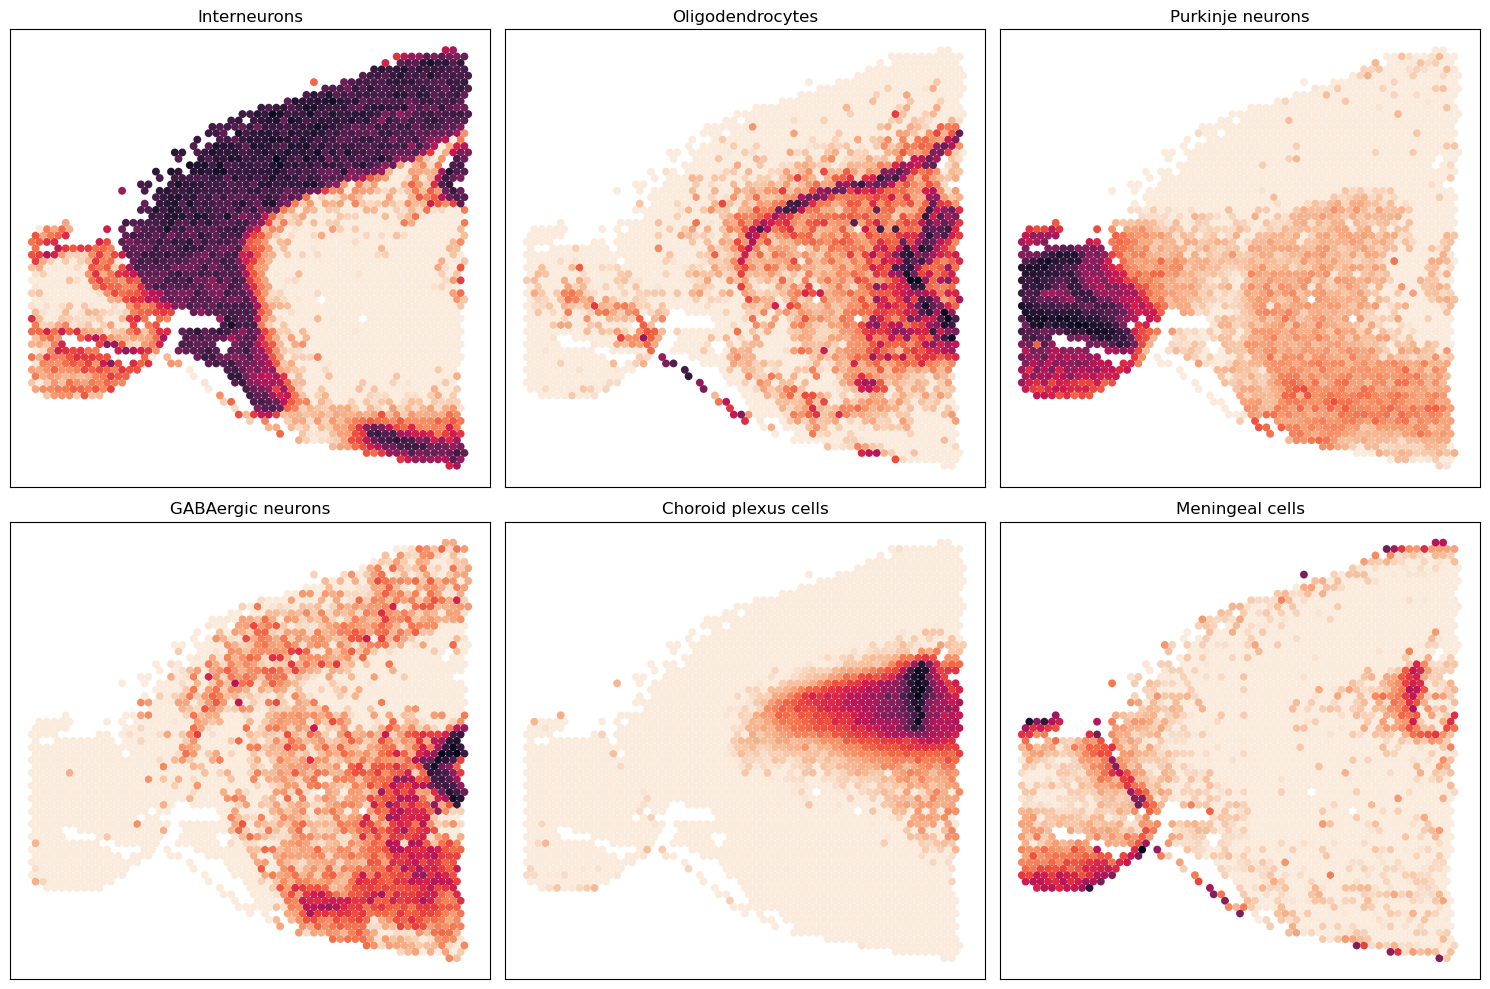

In [61]:
ncols = 3
nrows = ((len(relevant_factors) + ncols - 1) // ncols)
fig, axs = plt.subplots(nrows, ncols, sharex=True, sharey=True, figsize=(ncols * 5, nrows * 5), squeeze=False)
for i, rf in enumerate(relevant_factors):
    ax = sns.scatterplot(
        pd.concat([z_df, cov_df], axis=1), 
        # pd.concat([model.data["group_1"]["view_1"].to_df(), cov_df], axis=1), 
        x=0, 
        y=1, 
        hue=rf, 
        s=32, 
        palette=sns.color_palette("rocket_r", as_cmap=True),
        ax=axs[i // ncols, i % ncols],
        linewidth=0.0, 
        alpha = 1.0,
        rasterized=True,
        legend=False
    )
    # sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
    ax.set_title(rf)
    ax.set(xlabel=None)
    ax.set(ylabel=None)
    # ax.set_xticks(ticks=[], labels=[])
    # ax.set_yticks(ticks=[], labels=[])

plt.xticks(ticks=[], labels=[])
plt.yticks(ticks=[], labels=[])
fig.tight_layout()
plt.show()

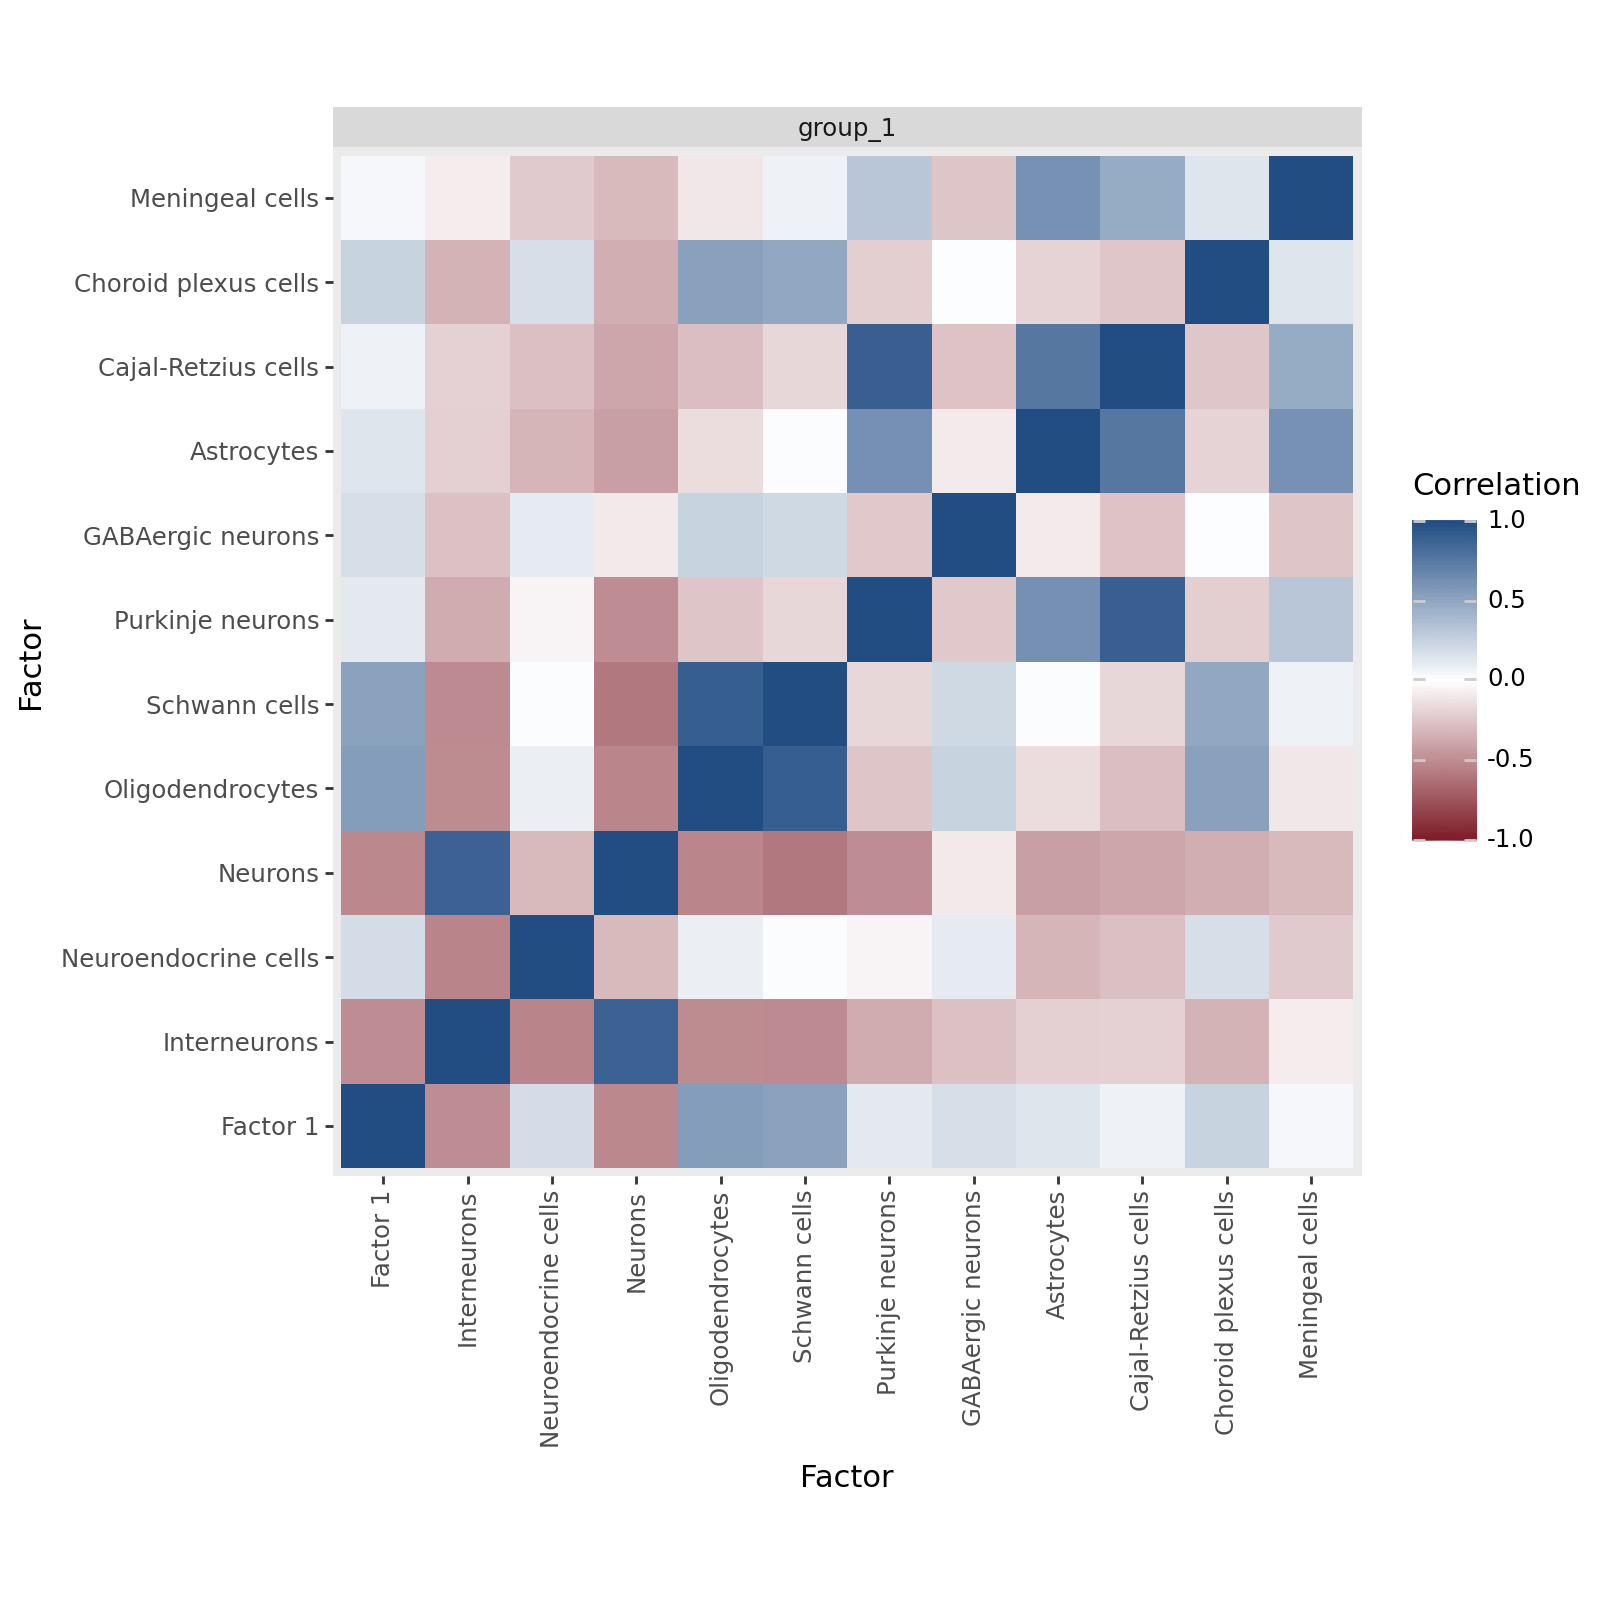

In [26]:
plotting.plot_factor_correlation(model, top=12)

In [38]:
from prismo import plotting

Index(['Factor 1', 'Interneurons', 'Neuroendocrine cells', 'Neurons',
       'Oligodendrocytes', 'Schwann cells', 'Purkinje neurons',
       'GABAergic neurons', 'Astrocytes', 'Cajal-Retzius cells',
       'Choroid plexus cells', 'Meningeal cells', 'Retinal ganglion cells',
       'Pyramidal cells', 'Satellite glial cells',
       'Oligodendrocyte progenitor cells', 'Tanycytes', 'Ependymal cells',
       'Bergmann glia', 'Microglia', 'Trigeminal neurons', 'Neuroblasts',
       'Neural stem/precursor cells', 'Dopaminergic neurons',
       'Immature neurons', 'in_tissue', 'array_row', 'array_col',
       'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts',
       'log1p_total_counts', 'pct_counts_in_top_50_genes',
       'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes',
       'pct_counts_in_top_500_genes', 'total_counts_mt',
       'log1p_total_counts_mt', 'pct_counts_mt', 'n_counts'],
      dtype='object')


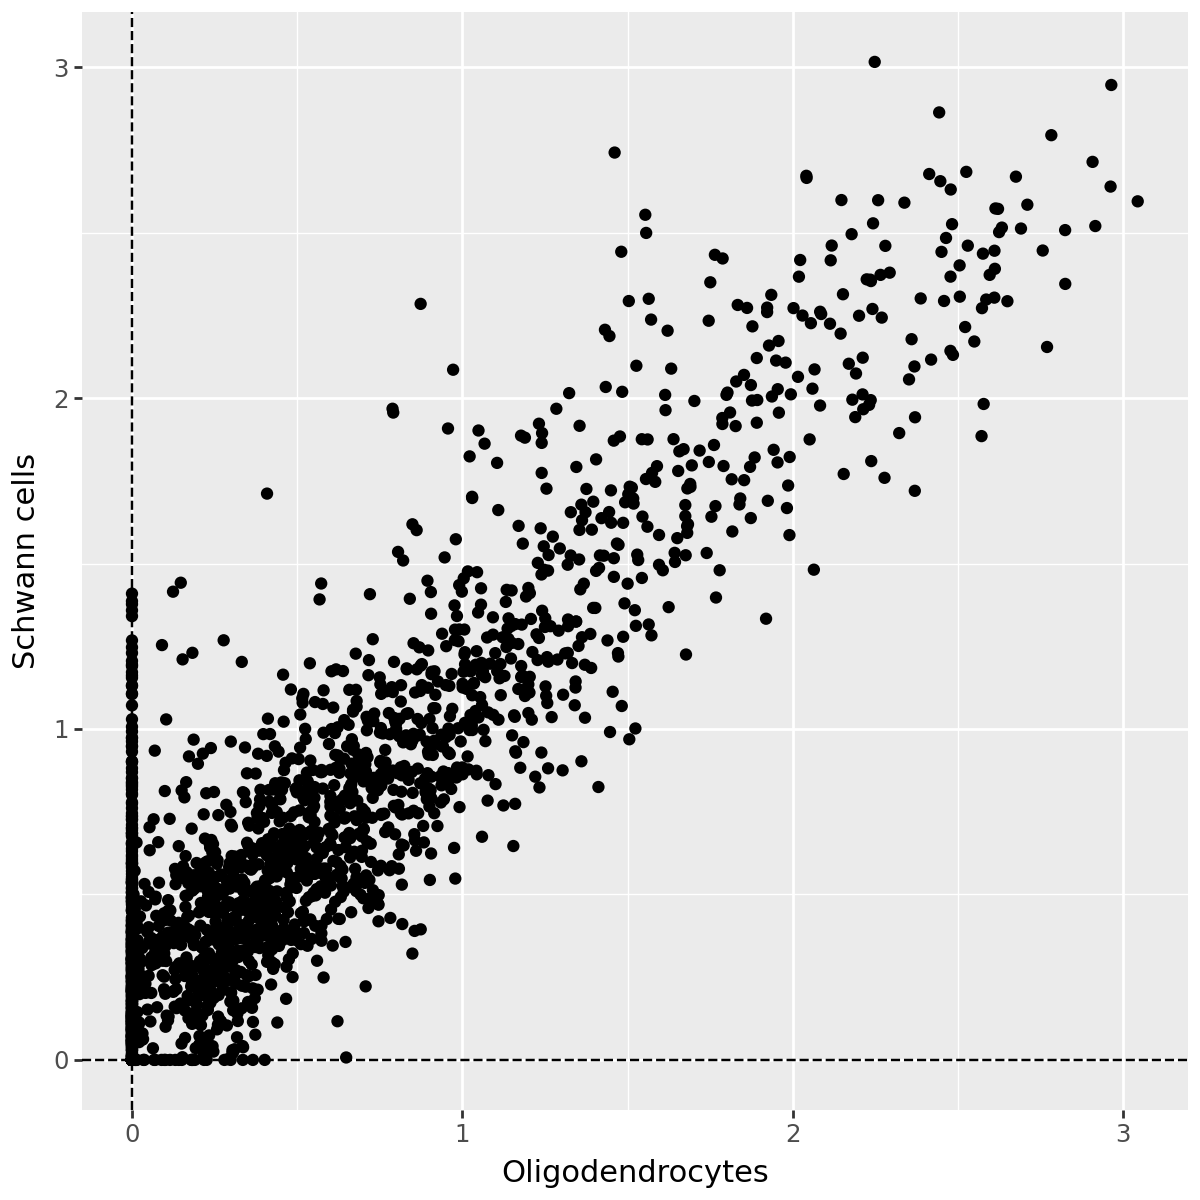

In [40]:
plotting.plot_factors_scatter(model, "Oligodendrocytes", "Schwann cells")

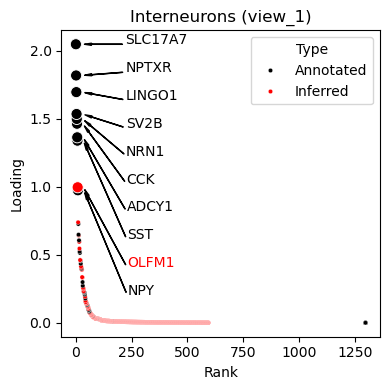

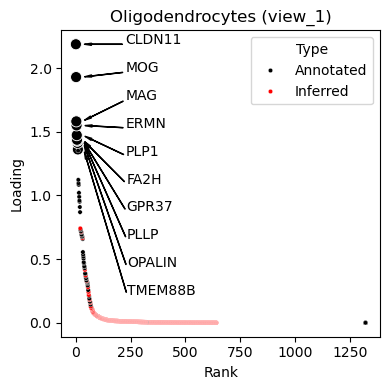

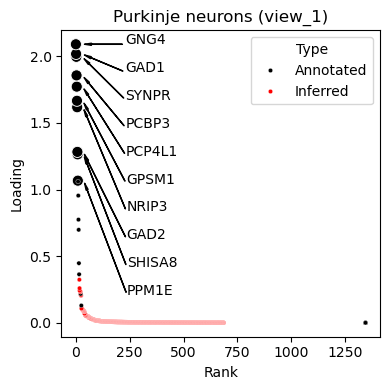

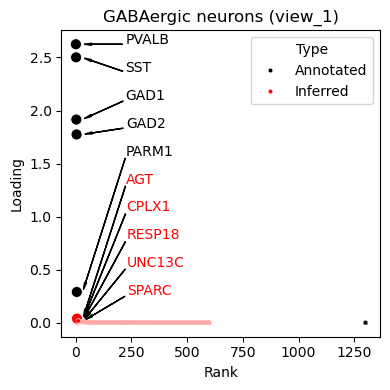

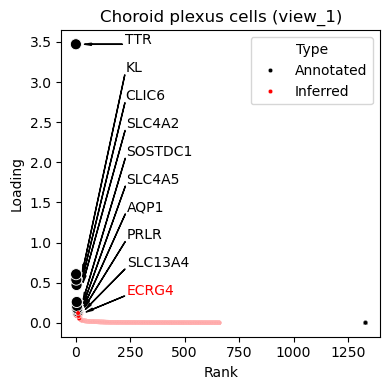

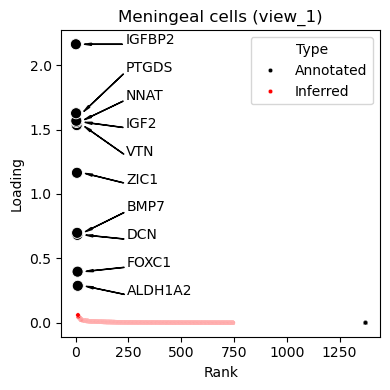

In [62]:
for rf in relevant_factors:
    plotting.plot_top_weights_muvi(model, rf, figsize=(4,4), top=10)
    plt.show()

In [92]:
top=20
weights_1 = model.get_weights("dataframe")["view_1"].loc["Purkinje neurons"].sort_values(ascending=False).iloc[:top].index
weights_2 = model.get_weights("dataframe")["view_1"].loc["Cajal-Retzius cells"].sort_values(ascending=False).iloc[:top].index

In [93]:
len(set(weights_1) & set(weights_2))

3